# MVP

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# AWS Libraries
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Geo-mapping Libraries
import geopandas
import geopy
import folium 

# Helper Functions
import MVP_acquire_ds, MVP_explore

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

### Download the JSON Files from AWS S3 Bucket

In [2]:
# Create the s3 resource object
s3 = boto3.resource('s3')

# Download the json files from AWS

s3.Bucket("dspreparedjobpostings").download_file("df_ds_tx_prepared_backup.json", 
                                                 "df_ds_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of data scientist positions in TX
print("Last modified datetime for data scientist positions in TX: ", 
      s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json').last_modified)

s3.Bucket("wdpreparedjobpostings").download_file("df_wd_tx_prepared_backup.json", 
                                                 "df_wd_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of web developer positions in TX
print("Last modified datetime for web developer positions in TX: ", 
      s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json').last_modified)

Last modified datetime for data scientist positions in TX:  2021-03-03 17:22:30+00:00
Last modified datetime for web developer positions in TX:  2021-03-03 17:25:07+00:00


## Data Preparation

### Load JSON Files into Dataframe and Set the Date as the Index

In [3]:
# Read the json file and convert it to pandas dataframe

df_ds = pd.read_json('df_ds_tx_prepared_backup.json')
df_wd = pd.read_json('df_wd_tx_prepared_backup.json')

# Set the date column as the index and sort the index

df_ds.date = pd.to_datetime(df_ds.date)
df_ds = df_ds.set_index('date').sort_index(ascending=False)
df_wd.date = pd.to_datetime(df_wd.date)
df_wd = df_wd.set_index('date').sort_index(ascending=False)

# Print the number of job postings in each dataframe

print("Number of data scientist job postings in TX: ", df_ds.shape[0])
print("Number of web developer job postings in TX: ", df_wd.shape[0])

Number of data scientist job postings in TX:  2513
Number of web developer job postings in TX:  4902


In [4]:
# Print the concise summary of the dataframe df_ds
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2021-03-03 to 2020-12-22
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            2513 non-null   object 
 1   company          2513 non-null   object 
 2   company_rating   2513 non-null   float64
 3   job_link         2513 non-null   object 
 4   job_description  2513 non-null   object 
 5   city             2513 non-null   object 
 6   state            2513 non-null   object 
 7   zipcode          2513 non-null   int64  
 8   clean            2513 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 196.3+ KB


In [5]:
# Print the concise summary of the dataframe df_wd
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4902 entries, 2021-03-03 to 2021-01-04
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4902 non-null   object 
 1   company          4902 non-null   object 
 2   company_rating   4902 non-null   float64
 3   job_link         4902 non-null   object 
 4   job_description  4902 non-null   object 
 5   city             4902 non-null   object 
 6   state            4902 non-null   object 
 7   zipcode          4902 non-null   int64  
 8   clean            4902 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 383.0+ KB


In [6]:
# Print the first 5 rows of the dataframe df_ds
df_ds.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-03-03,"Master Data Management, Consultant - Analytics...",Deloitte,4.000000,https://www.indeed.com/rc/clk?jk=c9eba1536579c...,"Master Data Management, Consultant - (Informat...",Austin,TX,0,master data management consultant informatica ...
2021-03-03,Software Engineer - Corporate Technology | Mac...,"JPMorgan Chase Bank, N.A.",3.900000,https://www.indeed.com/rc/clk?jk=12eefa4b4fc44...,"As a member of our Software Engineering Group,...",Lewisville,TX,0,member software engineering group look first f...
2021-03-03,CCB -Home Lending - Data Scientist - Marketing...,"JPMorgan Chase Bank, N.A.",3.900000,https://www.indeed.com/rc/clk?jk=c9f0b67af9768...,Are you excited when a marketing offer finds y...,Plano,TX,0,excited marketing offer find right time marvel...
2021-03-03,Data Scientist - Utility Analytics,Koch Engineered Solutions,3.600000,https://www.indeed.com/rc/clk?jk=1d416a69e675d...,Description\nSentient Energy - a Koch Engineer...,Frisco,TX,75035,description sentient energy koch engineered so...
2021-03-03,Data Scientist,Guardian Premier Solutions LLC,3.772121,https://www.indeed.com/rc/clk?jk=356b5fe5114d7...,Job Summary:\n\nThe Data Scientist will apply ...,San Antonio,TX,78253,job summary data scientist apply statistical t...


In [7]:
# Print the first 5 rows of the dataframe df_wd
df_wd.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-03-03,Senior Developer - Front End,"Katapult Group, Inc.",3.70383,https://www.indeed.com/rc/clk?jk=85947c73b0c89...,About Katapult\n\nKatapult is a FinTech compan...,Plano,TX,75024,katapult katapult fintech company based new yo...
2021-03-03,Software Engineer II - Full Stack - Agency,The Zebra,3.80000,https://www.indeed.com/rc/clk?jk=9d6ad4d3dfc26...,INTRODUCTION\nThe Zebra is expanding our engin...,Austin,TX,78758,introduction zebra expanding engineering team ...
2021-03-03,"Web Developer - Work From Home (Dallas, TX Based)",BT Furnishings,3.80000,https://www.indeed.com/rc/clk?jk=b074b4d1f35b6...,About BT Furnishings:\n\nBT Furnishings is a f...,Dallas,TX,75237,bt furnishing bt furnishing family owned opera...
2021-03-03,Lead Automated Test Engineer,Tri-Starr Technology,3.70383,https://www.indeed.com/company/Tri--Starr-Tech...,The Lead Automated Test Engineer will work clo...,Live Oak,TX,78233,lead automated test engineer work closely endu...
2021-03-03,"Angular Developer-Fulltime -Irving,TX",Arthur Grand Technologies Inc,3.70383,https://www.indeed.com/rc/clk?jk=758755e8a20f0...,Company Description\nPosition: Angular Develop...,Houston,TX,0,company description position angular developer...


### Brief Summary of the Job Postings

#### Data Scientist Position

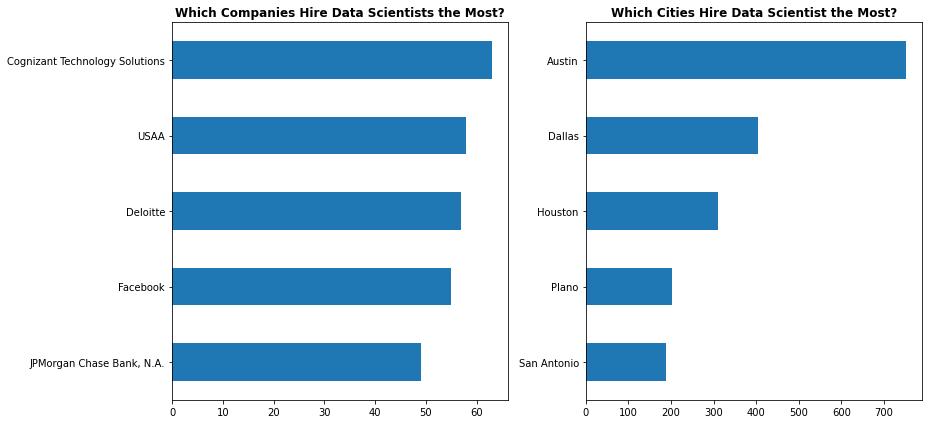

In [8]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_ds.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Data Scientists the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_ds.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Data Scientist the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# How does the number of job postings change over time?
df_ds.resample('W').title.count()

date
2020-12-27    392
2021-01-03    136
2021-01-10    212
2021-01-17    187
2021-01-24    352
2021-01-31    295
2021-02-07    268
2021-02-14    294
2021-02-21    175
2021-02-28    147
2021-03-07     55
Freq: W-SUN, Name: title, dtype: int64

In [10]:
# Which company has the best avereage rating? 
df_ds.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Digital Pharmacist    5.0
Rekruiters            5.0
Onit                  4.7
Levelset              4.7
Harnham               4.6
Name: company_rating, dtype: float64

In [11]:
df_ds.title.value_counts().head()

Data Scientist               265
Senior Data Scientist         93
Senior Data Analyst           56
Machine Learning Engineer     53
Principal Data Scientist      40
Name: title, dtype: int64

#### Web Developer Position

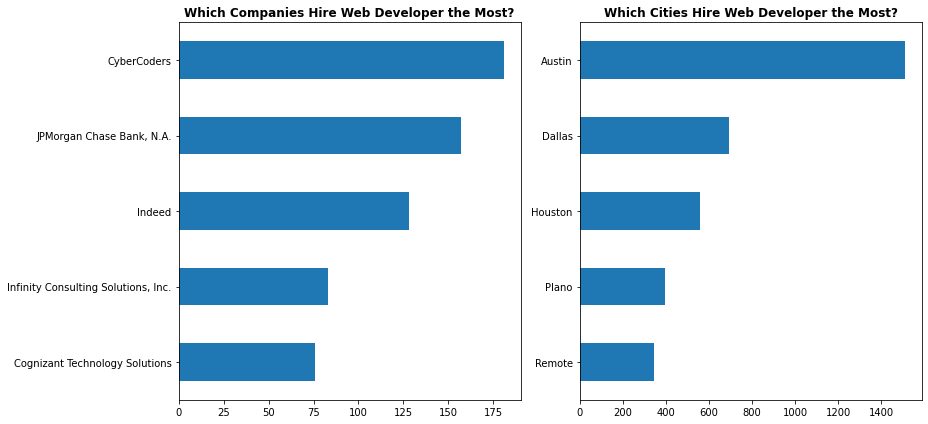

In [12]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_wd.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Web Developer the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_wd.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Web Developer the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# How does the number of job postings change over time?
df_wd.resample('W').title.count()

date
2021-01-10      62
2021-01-17     346
2021-01-24     793
2021-01-31    1054
2021-02-07     825
2021-02-14     786
2021-02-21     449
2021-02-28     449
2021-03-07     138
Freq: W-SUN, Name: title, dtype: int64

In [14]:
# Which company has the best avereage rating? 
df_wd.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Box                             5.0
MPIRE Technology Group, Inc.    5.0
Royal & Ross                    5.0
Givelify                        5.0
RightNow Ministries             5.0
Name: company_rating, dtype: float64

In [15]:
df_wd.title.value_counts().head()

Web Developer               109
Software Engineer           107
Software Developer           79
Senior Software Engineer     78
Full Stack Developer         68
Name: title, dtype: int64

### Top k Needed Skills

#### Data Scientist Position
- Tech Skills
- Soft Skills
- General Skills (Combination of Tech+Soft)

In [16]:
# Create a tech library
ds_tech_library = ['python','sql','pandas','numpy','matplotlib','scikit learn','scikitlearn','spark','hadoop',
                'aws','amazon web services','azure','microsoft word', 'microsoft excel','excel','tableau',
                'tensor flow','pytorch','hive','impala','matlab','etl','statistics','exploration',
                'extraction','data wrangling','math','machine learning','data visualization','java','js',
                'javascript','scala','r','c','c++','power bi','dashboard','linear algebra','calculus',
                'neural networks','eda','big data','frameworks','database management','testing hypotheses',
                'probability','data mining','perl','nosql','saas','git','github','natural language processing',
                'nlp', 'deep learning','agile','kanban','project management','julia','devops','google cloud',
                'pytorch','computer vision', 'deep neural networks','neural networks','amazon web services',
                'natural language processing','extract,transform,load','mysql','structured query language']

In [17]:
# Print the number of skills in the library
print("Number of data science skills in tech skill library: ", len(ds_tech_library))

# Print the top 5 needed tech skills

ds_top_tech = MVP_explore.top_skills(df_ds, 5, ds_tech_library, 'tech')
ds_top_tech

Number of data science skills in tech skill library:  71
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
Y
Enter the INITIALS of the job title:
ds


,top5_tech_skills,frequency
0,machine learning,3823.0
1,python,2034.0
2,sql,1544.0
3,aws,1196.0
4,r,1114.0


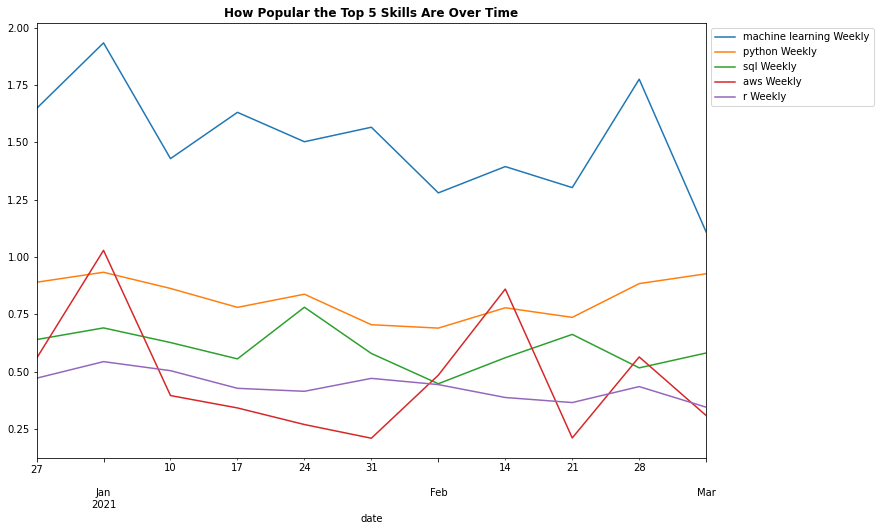

In [18]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_tech)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_tech)

In [19]:
# Create a soft skill library
ds_soft_library = ['critical thinking','communication','problem solving','teamwork','ethics','business acumen',
                'interpersonal skills','curiosity','storytelling','adaptability','team player','collaboration',
                'time management','leadership','domain knowledge','creativity','decision making',
                'verbal communication','written communication','teamwork']

In [20]:
# Print the number of skills in the library
print("Number of data science skills in soft skill library: ", len(ds_soft_library))

# Print the top 5 needed soft skills

ds_top_soft = MVP_explore.top_skills(df_ds, 5, ds_soft_library, 'soft')
ds_top_soft

Number of data science skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_soft_skills,frequency
0,communication,1715.0
1,leadership,1084.0
2,collaboration,503.0
3,problem solving,372.0
4,written communication,284.0


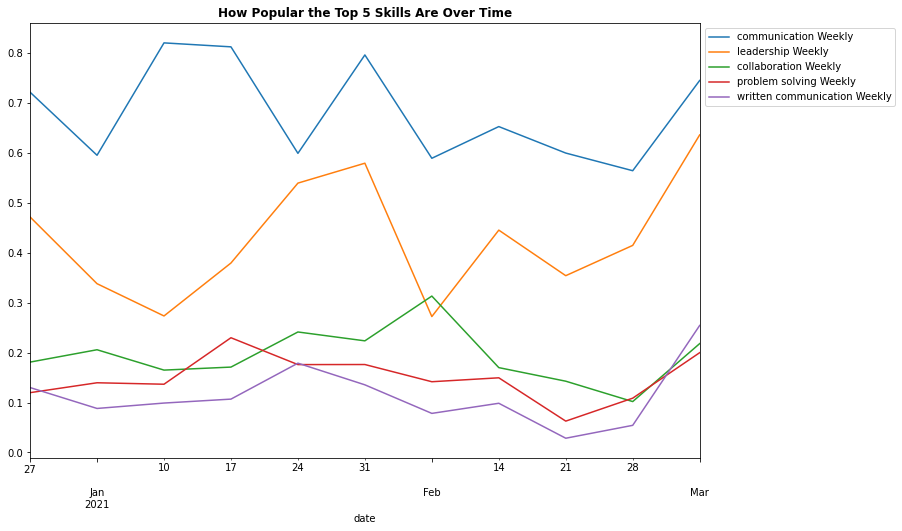

In [21]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_soft)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_soft)

In [22]:
# Create a general library
ds_general_library = ['python','sql','pandas','numpy','matplotlib','scikit learn','scikitlearn','spark','hadoop',
                'aws','amazon web services','azure','microsoft word', 'microsoft excel','excel','tableau',
                'tensor flow','pytorch','hive','impala','matlab','etl','statistics','exploration',
                'extraction','data wrangling','math','machine learning','data visualization','java','js',
                'javascript','scala','r','c','c++','power bi','dashboard','linear algebra','calculus',
                'neural networks','eda','big data','frameworks','database management','testing hypotheses',
                'probability','data mining','perl','nosql','saas','git','github','natural language processing',
                'nlp', 'deep learning','agile','kanban','project management','julia','devops','google cloud',
                'pytorch','computer vision', 'deep neural networks','neural networks','amazon web services',
                'natural language processing','extract,transform,load','mysql','structured query language'
                'critical thinking','communication','problem solving','teamwork','ethics','business acumen',
                'interpersonal skills','curiosity','storytelling','adaptability','team player','collaboration',
                'time management','leadership','domain knowledge','creativity','decision making',
                'verbal communication','written communication','teamwork']

In [23]:
# Print the number of skills in the library
print("Number of data science skills in general skills library: ", len(ds_general_library))

# Print the top 5 needed general skills

ds_top_general = MVP_explore.top_skills(df_ds, 5, ds_general_library, 'general')
ds_top_general

Number of data science skills in general skills library:  90
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_general_skills,frequency
0,machine learning,3823.0
1,python,2034.0
2,communication,1715.0
3,sql,1544.0
4,aws,1196.0


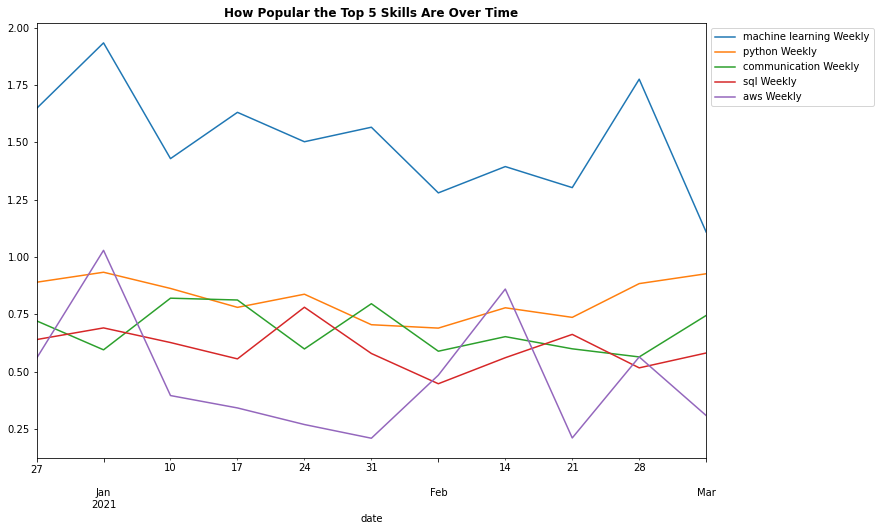

In [24]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_general)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_general)

#### Web Developer Position
- Tech skills
- Soft skills
- General Skills (Combination of Tech+Soft)

In [25]:
# Create a tech library
wd_tech_library = ['html','css','javascript','debugging','git','github','libraries','frameworks','publishing web site',
'photoshop','bootstrap','jquery','search engine optimization','seo','basic graphic design','front end','back end',
'visual studio code','visual studio','figma','zeplin','sketch','gatspy','strapi','paint','canva','aws','azure',
'amazon web services','sql','mysql','nosql','node','node.js','js','json','api','google charts','d3','d3.js','react',
'angular','ember','vue','python','c','c++','ruby','ruby on rails','git','github','php','net','.net','java','c#',
'linux','go','gcp','troubleshooting','problem solving','ux','ui','ux/ui','cloud computing','netlify','net']  

In [26]:
# Print the number of skills in the library
print("Number of web dev skills in tech skill library: ", len(wd_tech_library))

# Print the top 5 needed tech skills

wd_top_tech = MVP_explore.top_skills(df_wd, 5, wd_tech_library, 'tech')
wd_top_tech

Number of web dev skills in tech skill library:  67
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_tech_skills,frequency
0,javascript,3884.0
1,java,2613.0
2,sql,2380.0
3,react,2079.0
4,net,1941.0


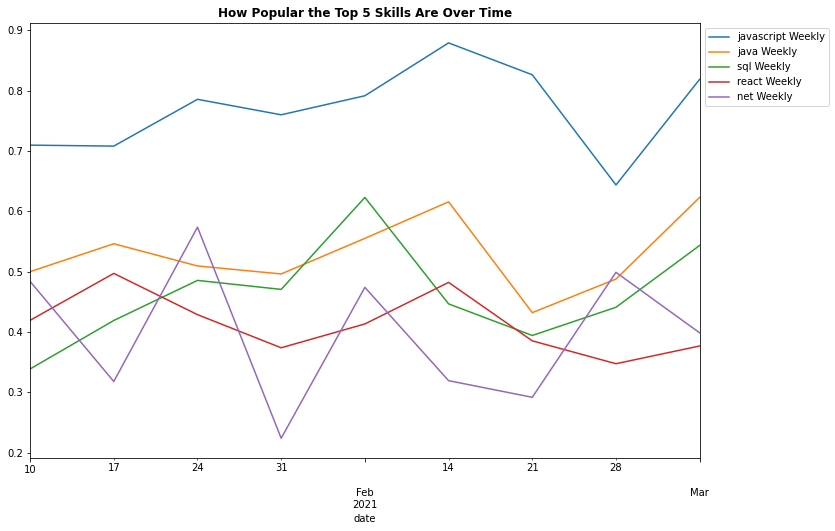

In [27]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_tech)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_tech)

In [28]:
# Create a soft library
wd_soft_library = ['critical thinking','communication','problem solving','teamwork','ethics','business acumen',
                'interpersonal skills','curiosity','storytelling','adaptability','team player','collaboration',
                'time management','leadership','domain knowledge','creativity','decision making',
                'verbal communication','written communication','teamwork']

In [29]:
# Print the number of skills in the library
print("Number of web dev skills in soft skill library: ", len(wd_soft_library))

# Print the top 5 needed soft skills

wd_top_soft = MVP_explore.top_skills(df_wd, 5, wd_soft_library, 'soft')
wd_top_soft

Number of web dev skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
wd


,top5_soft_skills,frequency
0,communication,2872.0
1,leadership,1116.0
2,collaboration,757.0
3,problem solving,616.0
4,written communication,439.0


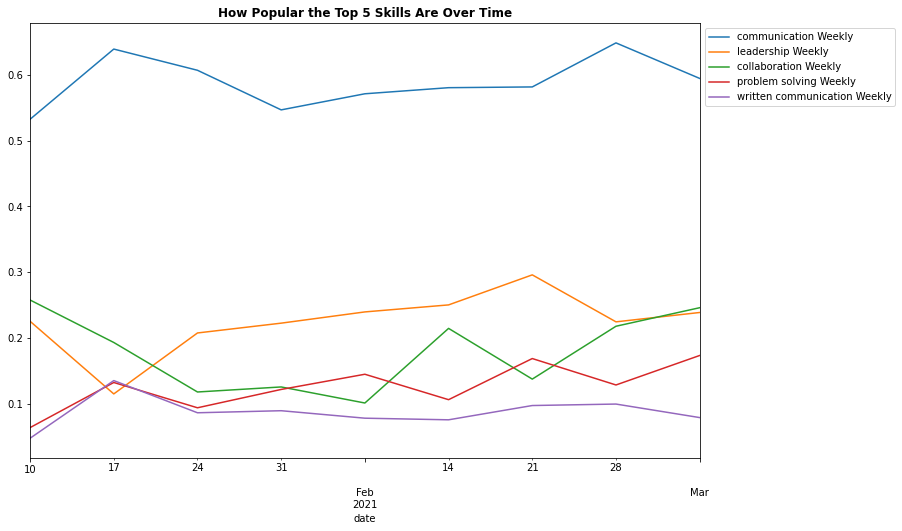

In [30]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_soft)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_soft)

In [31]:
# Create a general library
wd_general_library = ['html','css','javascript','debugging','git','github','libraries','frameworks','publishing web site',
'photoshop','bootstrap','jquery','search engine optimization','seo','basic graphic design','front end','back end',
'visual studio code','visual studio','figma','zeplin','sketch','gatspy','strapi','paint','canva','aws','azure',
'amazon web services','sql','mysql','nosql','node','node.js','js','json','api','google charts','d3','d3.js','react',
'angular','ember','vue','python','c','c++','ruby','ruby on rails','git','github','php','net','.net','java','c#',
'linux','go','gcp','troubleshooting','problem solving','ux','ui','ux/ui','cloud computing','netlify','net''critical thinking',
'communication','problem solving','teamwork','ethics','business acumen','interpersonal skills','curiosity',
'storytelling','adaptability','team player','collaboration','time management','leadership','domain knowledge',
'creativity','decision making','verbal communication','written communication','teamwork']

In [32]:
# Print the number of skills in the library
print("Number of web dev skills in general skill library: ", len(wd_general_library))

# Print the top 5 needed general skills

wd_top_general = MVP_explore.top_skills(df_wd, 5, wd_general_library, 'general')
wd_top_general

Number of web dev skills in general skill library:  86
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_general_skills,frequency
0,javascript,3884.0
1,communication,2872.0
2,java,2613.0
3,sql,2380.0
4,react,2079.0


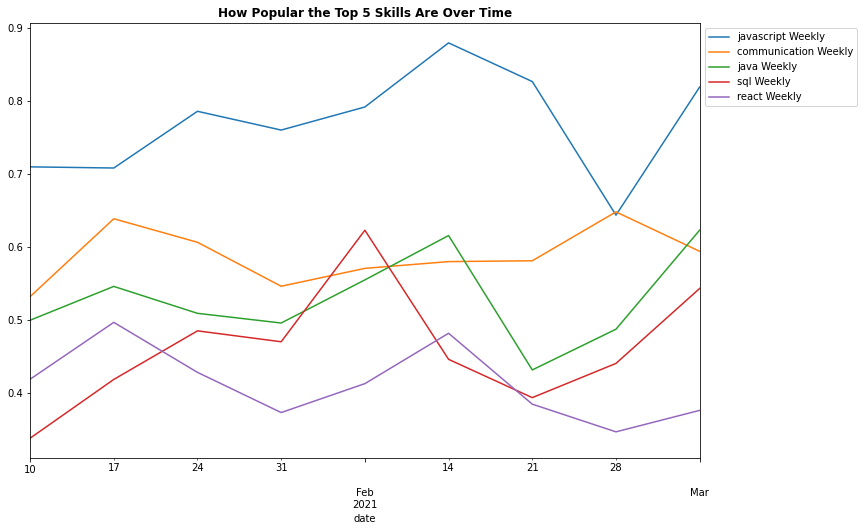

In [33]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_general)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_general)